#Importing Libraries  

In [1]:
!pip install --upgrade keras
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from keras import initializers, layers
import keras
from sklearn.datasets import make_classification
from tensorflow import keras
!pip install keras-tuner --upgrade
from keras_tuner import Hyperband




# Loading Dataset

In [2]:
#tf.random.set_seed(0)#Setting Random Seed for fixed random

keras.utils.set_random_seed(812)

dataset = pd.read_csv('MAIN.csv')

# Data Preprocessing

In [3]:
data = dataset.iloc[:300,:7]# Get rid of blank spaces
print(data.isna().sum())# Initial Summary
print(data.head)
#Get Rid of year column and make it index column to work better with model
data.index = pd.to_datetime(data.Year,errors='coerce')
data = data.drop('Year', axis=1)

# Find NaN value
data.isna().sum()
data = data.fillna(method='ffill')#Forward Fill missing values
data = data.resample('M').mean()# Format index to YYYY-MM-DD
data.isna().sum()
data = data.fillna(method='ffill')
data.isna().sum()

futureData = data

data = data.iloc[:229,:]# Get rid of blank spaces

Year                    0
Unenployment Rates     70
Population             71
Avg Price              71
Inflation              71
Interest               72
Vacancy               282
dtype: int64
<bound method NDFrame.head of            Year  Unenployment Rates  Population  Avg Price  Inflation  \
0    2005-01-01                 9.8       267.7   193300.0        1.9   
1    2005-02-01                 9.0       267.9   193900.0        1.9   
2    2005-03-01                 8.6       268.1   194800.0        1.9   
3    2005-04-01                 8.2       268.3   195000.0        2.0   
4    2005-05-01                 8.5       268.5   195100.0        1.9   
..          ...                 ...         ...        ...        ...   
295  2029-08-01                 NaN         NaN        NaN        NaN   
296  2029-09-01                 NaN         NaN        NaN        NaN   
297  2029-10-01                 NaN         NaN        NaN        NaN   
298  2029-11-01                 NaN         N

# Feature Correlation

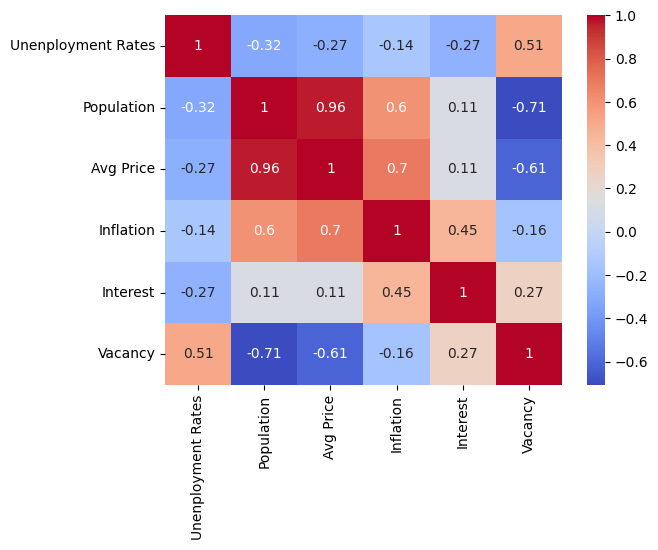

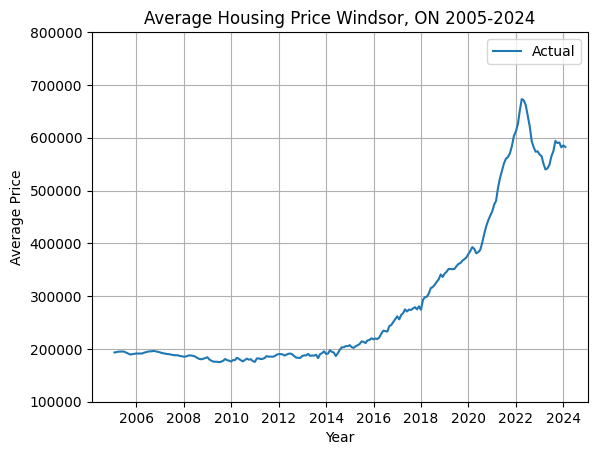

In [4]:
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

plt.plot(data.index, data.iloc[:,2], label='Actual')


plt.title('Average Housing Price Windsor, ON 2005-2024')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.legend()
plt.ylim(100000, 800000)
plt.grid(True)
plt.show()

#Scale Data

In [5]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create Sequence

In [6]:
seq_n = 1

X=[]
Y=[]
for i in range(len(scaled_data)-seq_n):
  X.append(scaled_data[i:i+seq_n, :])
  Y.append(scaled_data[i+seq_n, :])

X = np.array(X)
Y = np.array(Y)


print(Y)
X = X.reshape(1, 228, 6)
Y = Y.reshape(1, 228, 6)

[[0.34920635 0.0037037  0.03832263 0.17647059 0.47368421 0.575     ]
 [0.31746032 0.00740741 0.04012841 0.17647059 0.47368421 0.575     ]
 [0.28571429 0.01111111 0.0405297  0.19607843 0.47368421 0.575     ]
 ...
 [0.1984127  0.96111111 0.81661316 0.56862745 1.         0.        ]
 [0.20634921 0.97962963 0.82383628 0.56862745 1.         0.        ]
 [0.15873016 1.         0.81801766 0.47058824 1.         0.        ]]


# Create First LSTM Model

In [7]:
def encoder_model(hp):
  #Training Model
  model = Sequential()
  model.add(tf.keras.Input((None,6)))
  model.add(LSTM(128, return_sequences=True, activation=hp.Choice("activation", ['relu','tanh']) ) )#
  model.add(Dropout(0.2))
  model.add(LSTM(6, return_sequences=True))
  #model.add(Dense(6))
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['accuracy'])#
  return model

#Create Tuner and Find best parameters for loss

In [8]:
tuner = Hyperband(
    encoder_model,
    objective='loss',
    max_epochs=100,
    directory='my_dir',
    project_name='intro_to_kt')

tuner.search(X, Y, epochs=10, batch_size = 1)


Reloading Tuner from my_dir/intro_to_kt/tuner0.json


#Train Model

In [9]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(X, Y, epochs=100, batch_size=1)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.2544 - loss: 0.1476
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step - accuracy: 0.4342 - loss: 0.0599
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step - accuracy: 0.3070 - loss: 0.0501
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step - accuracy: 0.3026 - loss: 0.0377
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step - accuracy: 0.3904 - loss: 0.0277
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step - accuracy: 0.4956 - loss: 0.0184
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.5307 - loss: 0.0177
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step - accuracy: 0.6096 - loss: 0.0184
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step - accuracy: 0.5833 - loss: 0.0160
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step - accuracy: 0.5789 - loss: 0.0131
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step - accuracy: 0.5658 - loss: 0.0120
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.

# Plot Loss


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, None, 128)           │          69,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, None, 6)             │           3,240 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 217,082 (847.98 KB)

 Trainable params: 72,360 (282.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 144,722 (565.32 KB)

{'activation': 'tanh', 'lr': 0.009023397373850085, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 4, 'tuner/round': 4, 'tuner/trial_id': '0141'}



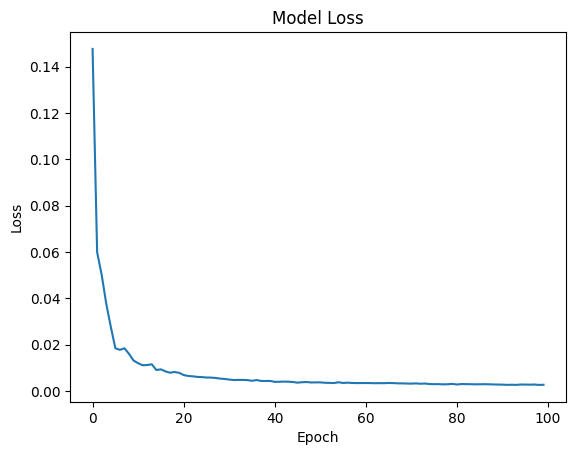

In [10]:

plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')


best_model.summary()
print(best_hps.values)
plt.savefig("test.svg", format="svg", dpi=1200)
print()
plt.show()

# Evaluation Metrics


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

predictions = best_model.predict(X)

# Calculate evaluation metrics
mae = mean_absolute_error(Y.reshape(228, 6), predictions.reshape(228, 6))
mse = mean_squared_error(Y.reshape(228, 6), predictions.reshape(228, 6))
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
Mean Absolute Error (MAE): 0.03056699211068964
Mean Squared Error (MSE): 0.0023497042743389866
Root Mean Squared Error (RMSE): 0.0484737483008998


# Plotting All predicted values subplots

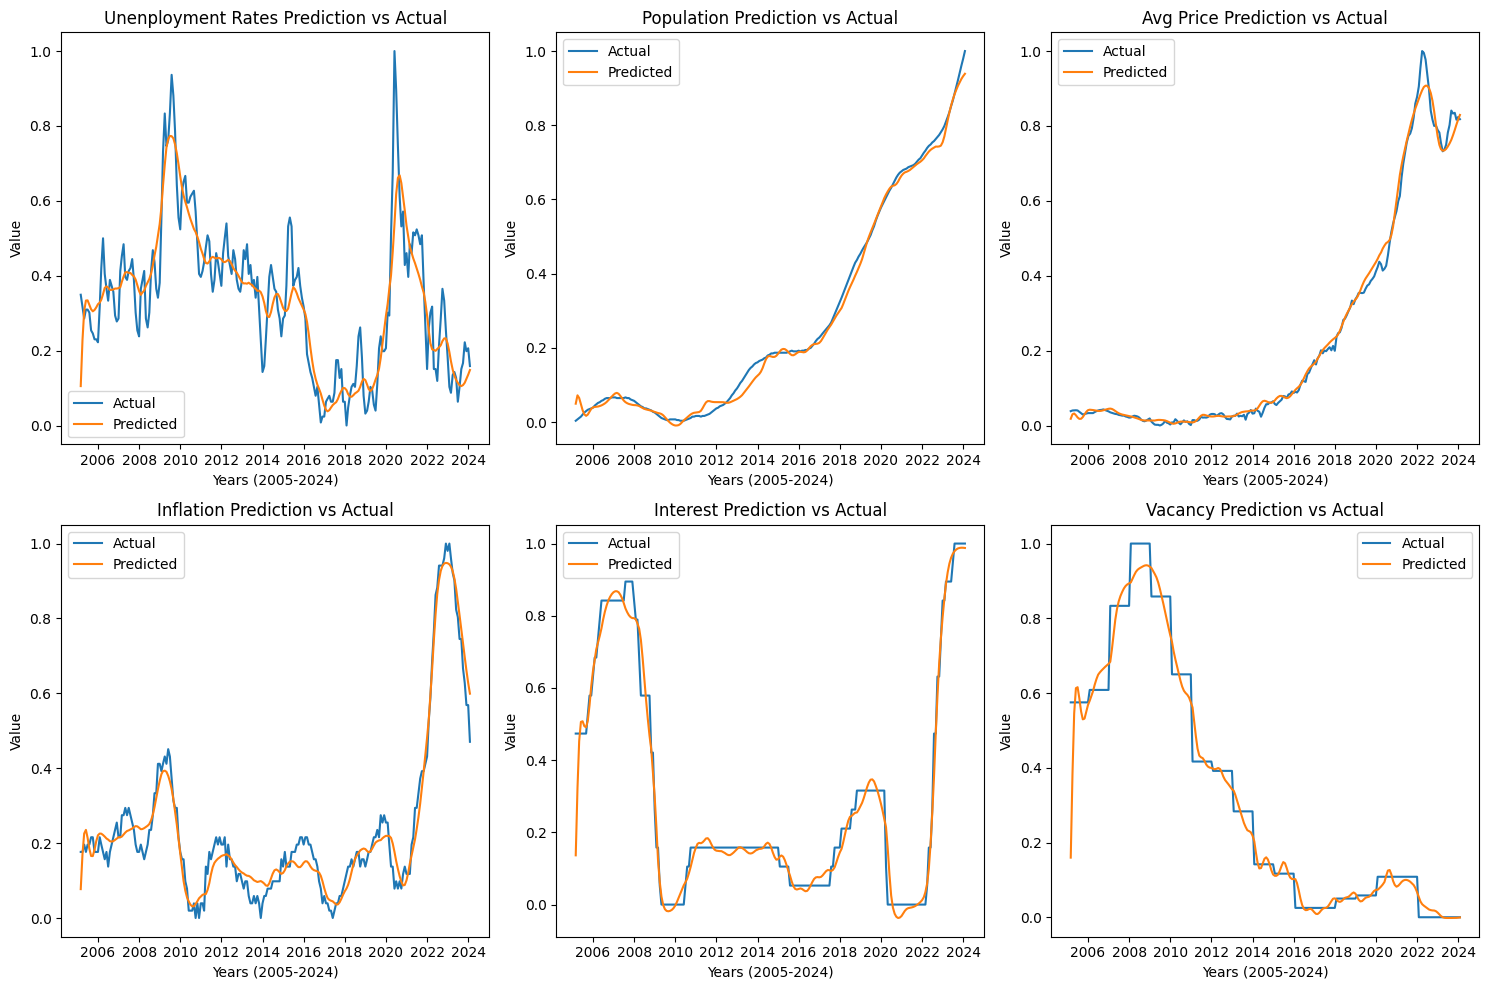

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, None, 128)           │          69,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, None, 6)             │           3,240 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 217,082 (847.98 KB)

 Trainable params: 72,360 (282.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 144,722 (565.32 KB)

{'activation': 'tanh', 'lr': 0.009023397373850085, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 4, 'tuner/round': 4, 'tuner/trial_id': '0141'}


In [12]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i,ax in enumerate(axes.flat):
    ax.plot(data.index[-228:], Y.reshape(228, 6)[:,i], label='Actual')
    ax.plot(data.index[-228:], predictions.reshape(228, 6)[:,i], label='Predicted')
    ax.set_title(f'{data.columns.tolist()[i]} Prediction vs Actual')
    ax.set_ylabel('Value')
    ax.set_xlabel('Years (2005-2024)')
    ax.legend()

plt.tight_layout()
plt.show()

best_model.summary()
print(best_hps.values)

image_format = 'svg' # e.g .png, .svg, etc.
image_name = 'featurePred.svg'

fig.savefig(image_name, format=image_format, dpi=1200)

# PLotting just unemployment pred

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, None, 128)           │          69,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, None, 6)             │           3,240 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 217,082 (847.98 KB)

 Trainable params: 72,360 (282.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 144,722 (565.32 KB)

{'activation': 'tanh', 'lr': 0.009023397373850085, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 4, 'tuner/round': 4, 'tuner/trial_id': '0141'}


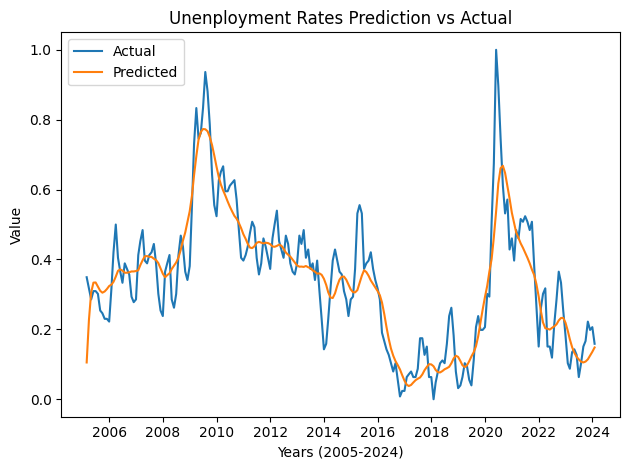

In [13]:

plt.plot(data.index[-228:], Y.reshape(228, 6)[:,0], label='Actual')
plt.plot(data.index[-228:], predictions.reshape(228, 6)[:,0], label='Predicted')
plt.title(f'{data.columns.tolist()[0]} Prediction vs Actual')
plt.ylabel('Value')
plt.xlabel('Years (2005-2024)')
plt.legend()

plt.tight_layout()


best_model.summary()
print(best_hps.values)

image_format = 'svg' # e.g .png, .svg, etc.
image_name = 'UnempfeaturePred.svg'

plt.savefig(image_name, format=image_format, dpi=1200)
plt.show()

# Create Prediction Model (Decoder)

In [14]:
newModel = Sequential()
newModel.add(tf.keras.Input(batch_size=1, shape=(None,6)))
newModel.add(LSTM(128, return_sequences=True, stateful=True))
newModel.add(Dropout(0.2))
newModel.add(LSTM(6, return_sequences=False, stateful=True))

#newModel.add(Dense(6,))

newModel.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

newModel.set_weights(best_model.get_weights())

# Predict N timesteps in the future

In [15]:
#newModel.reset_states()
newModel.layers[0].reset_states()
#first = newModel.predict(X).reshape(1,1,6)

future_predictions = []


forward_n =  48# Time Steps
nextpred = newModel.predict(X)#.reshape(1,1,6)


for i in range(forward_n):
  X = np.append( X[:, 1:, :] , nextpred.reshape(1,1,6), axis=1)
  nextpred = newModel.predict(X, verbose=0)
  future_predictions.append(nextpred)

#newModel.layers[0].reset_states()

future_predictions = np.array(future_predictions)

future_predictions = future_predictions.reshape(forward_n, 6)
final = scaler.inverse_transform(future_predictions)#[:,2]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


# Plot Forecasted Data

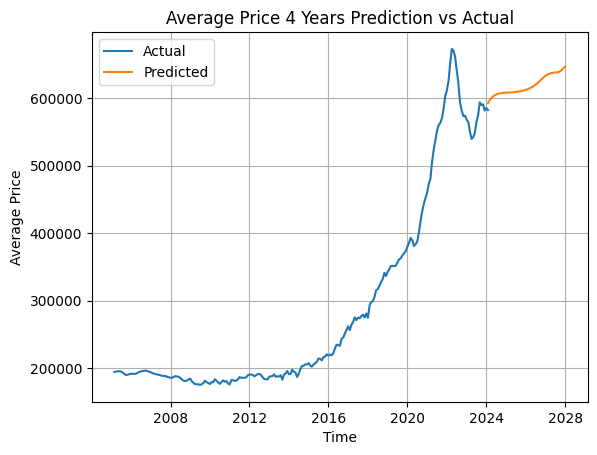

In [16]:
plt.plot(data.index[-228:], data.iloc[1:,2], label='Actual')
plt.plot(futureData.index[228:228+forward_n], final[:,2], label='Predicted')

plt.title('Average Price 4 Years Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
#plt.ylim(250, 400)
plt.grid(True)

image_format = 'svg' # e.g .png, .svg, etc.
image_name = 'Future.svg'

plt.savefig(image_name, format=image_format, dpi=1200)



plt.show()


# PLot all forecasted data (subplots

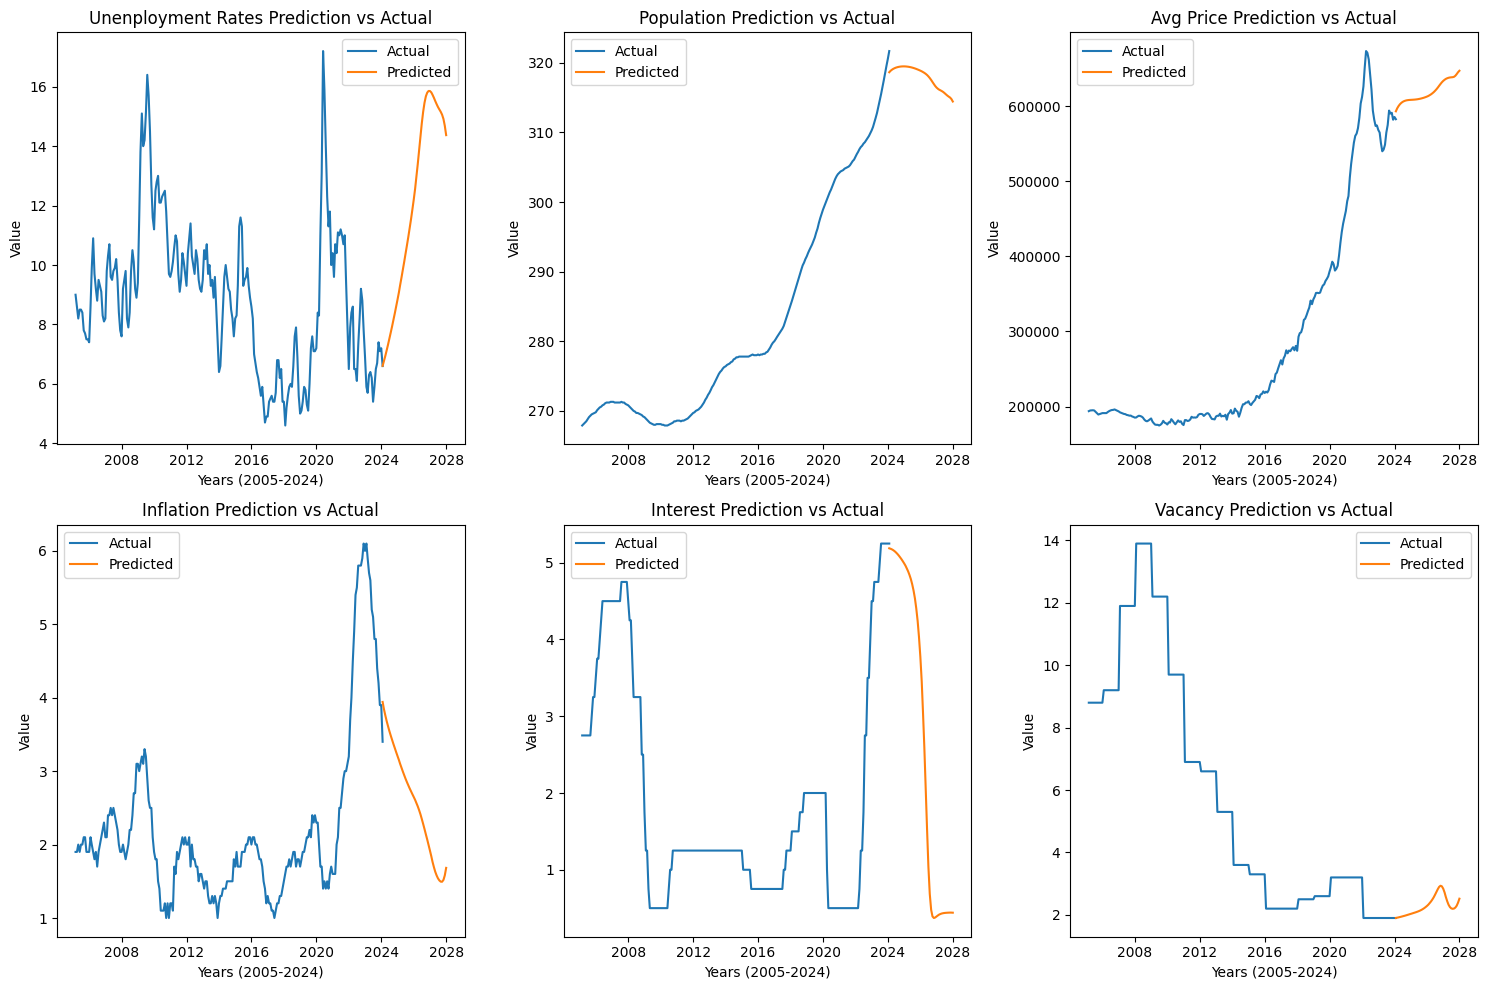

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, None, 128)           │          69,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, None, 6)             │           3,240 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 217,082 (847.98 KB)

 Trainable params: 72,360 (282.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 144,722 (565.32 KB)

{'activation': 'tanh', 'lr': 0.009023397373850085, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 4, 'tuner/round': 4, 'tuner/trial_id': '0141'}


In [17]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i,ax in enumerate(axes.flat):
    ax.plot(data.index[-228:], data.iloc[1:,i], label='Actual')
    ax.plot(futureData.index[228:228+forward_n], final[:,i], label='Predicted')
    ax.set_title(f'{data.columns.tolist()[i]} Prediction vs Actual')
    ax.set_ylabel('Value')
    ax.set_xlabel('Years (2005-2024)')
    ax.legend()

plt.tight_layout()
plt.show()

best_model.summary()
print(best_hps.values)

image_format = 'svg' # e.g .png, .svg, etc.
image_name = 'futurefeaturePred.svg'

fig.savefig(image_name, format=image_format, dpi=1200)

In [18]:
final[:,2]

array([593010.5 , 596898.5 , 599962.94, 602332.2 , 604136.3 , 605486.6 ,
       606471.7 , 607165.  , 607630.7 , 607928.9 , 608115.2 , 608239.2 ,
       608342.  , 608455.44, 608602.5 , 608799.4 , 609055.7 , 609375.8 ,
       609759.75, 610204.7 , 610708.1 , 611271.25, 611902.94, 612620.8 ,
       613450.44, 614422.06, 615564.9 , 616901.7 , 618449.5 , 620225.9 ,
       622252.2 , 624521.1 , 626943.06, 629347.1 , 631554.2 , 633439.56,
       634957.2 , 636129.2 , 637008.  , 637636.6 , 638036.6 , 638247.5 ,
       638417.94, 638917.5 , 640258.  , 642527.75, 645025.5 , 646986.6 ],
      dtype=float32)